

> #          **Brain tumor classification and segmentation**



---


In [1]:
!pip install medpy

     |████████████████████████████████| 153kB 15.9MB/s 
     |████████████████████████████████| 47.4MB 67kB/s 
  Created wheel for medpy: filename=MedPy-0.4.0-cp36-cp36m-linux_x86_64.whl size=753438 sha256=47136ee5284e5ff2e8fcfb3d4abda902bdf7e175ce4102a1ba6e399d8b7ce275
  Stored in directory: /root/.cache/pip/wheels/8c/c9/9c/2c6281c7a72b9fb1570862a4f028af7ce38405008354fbf870
Successfully built medpy


Importing all necessary libraries

In [2]:
import numpy as np
import pandas as pd

import torchvision
from torchvision import transforms

import torch, torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable

from torch.utils.data.dataset import Dataset
from skimage.transform import resize
import random

import matplotlib.pyplot as plt
import os
import h5py
from skimage.color import rgb2gray
from PIL import Image
from medpy.io import load
import itertools
import sys
import time

tumor_dict = {1: 'Meningioma tumor', 2: 'Glioma tumor', 3: 'Pituitary tumor', 0: 'No tumor'}

# Downloading data

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
!unzip '/content/drive/My Drive/672377_1183165_bundle_archive.zip'

Archive:  /content/drive/My Drive/672377_1183165_bundle_archive.zip
  inflating: Testing/glioma_tumor/image(1).jpg  
  inflating: Testing/glioma_tumor/image(10).jpg  
  inflating: Testing/glioma_tumor/image(100).jpg  
  inflating: Testing/glioma_tumor/image(11).jpg  
  inflating: Testing/glioma_tumor/image(12).jpg  
  inflating: Testing/glioma_tumor/image(13).jpg  
  inflating: Testing/glioma_tumor/image(14).jpg  
  inflating: Testing/glioma_tumor/image(15).jpg  
  inflating: Testing/glioma_tumor/image(16).jpg  
  inflating: Testing/glioma_tumor/image(17).jpg  
  inflating: Testing/glioma_tumor/image(18).jpg  
  inflating: Testing/glioma_tumor/image(19).jpg  
  inflating: Testing/glioma_tumor/image(2).jpg  
  inflating: Testing/glioma_tumor/image(20).jpg  
  inflating: Testing/glioma_tumor/image(21).jpg  
  inflating: Testing/glioma_tumor/image(22).jpg  
  inflating: Testing/glioma_tumor/image(23).jpg  
  inflating: Testing/glioma_tumor/image(24).jpg  
  inflating: Testing/glioma_tumor

In [5]:
!mkdir data

In [6]:
cd data

/content/data


In [7]:
!mkdir 3381290
!mkdir 3381293
!mkdir 3381296
!mkdir 3381302

In [8]:
cd ..

/content


In [9]:
!wget https://ndownloader.figshare.com/files/3381290
!wget https://ndownloader.figshare.com/files/3381293
!wget https://ndownloader.figshare.com/files/3381296
!wget https://ndownloader.figshare.com/files/3381302

--2020-12-06 11:02:25--  https://ndownloader.figshare.com/files/3381290
Resolving ndownloader.figshare.com (ndownloader.figshare.com)... 52.48.242.2, 34.246.17.89, 34.253.53.27, ...
Connecting to ndownloader.figshare.com (ndownloader.figshare.com)|52.48.242.2|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://s3-eu-west-1.amazonaws.com/pfigshare-u-files/3381290/brainTumorDataPublic_1766.zip [following]
--2020-12-06 11:02:25--  https://s3-eu-west-1.amazonaws.com/pfigshare-u-files/3381290/brainTumorDataPublic_1766.zip
Resolving s3-eu-west-1.amazonaws.com (s3-eu-west-1.amazonaws.com)... 52.218.37.59
Connecting to s3-eu-west-1.amazonaws.com (s3-eu-west-1.amazonaws.com)|52.218.37.59|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 214401279 (204M) [binary/octet-stream]
Saving to: ‘3381290’

3381290             100%[===================>] 204.47M  34.6MB/s    in 6.5s    

2020-12-06 11:02:32 (31.6 MB/s) - ‘3381290’ saved [214401279/

In [10]:
!unzip './3381290' -d './data/3381290'
!unzip './3381293' -d './data/3381293'
!unzip './3381296' -d './data/3381296'
!unzip './3381302' -d './data/3381302'

Archive:  ./3381290
  inflating: ./data/3381290/1.mat    
  inflating: ./data/3381290/10.mat   
  inflating: ./data/3381290/100.mat  
  inflating: ./data/3381290/101.mat  
  inflating: ./data/3381290/102.mat  
  inflating: ./data/3381290/103.mat  
  inflating: ./data/3381290/104.mat  
  inflating: ./data/3381290/105.mat  
  inflating: ./data/3381290/106.mat  
  inflating: ./data/3381290/107.mat  
  inflating: ./data/3381290/108.mat  
  inflating: ./data/3381290/109.mat  
  inflating: ./data/3381290/11.mat   
  inflating: ./data/3381290/110.mat  
  inflating: ./data/3381290/111.mat  
  inflating: ./data/3381290/112.mat  
  inflating: ./data/3381290/113.mat  
  inflating: ./data/3381290/114.mat  
  inflating: ./data/3381290/115.mat  
  inflating: ./data/3381290/116.mat  
  inflating: ./data/3381290/117.mat  
  inflating: ./data/3381290/118.mat  
  inflating: ./data/3381290/119.mat  
  inflating: ./data/3381290/12.mat   
  inflating: ./data/3381290/120.mat  
  inflating: ./data/3381290/12

In [11]:
!rm './3381290'
!rm './3381293'
!rm './3381296'
!rm './3381302'

# Creating custom dataset

In [12]:
class CustomDataset(Dataset):
    def __init__(self, path):

        self.to_tensor = transforms.ToTensor()
        self.data_path = path
        self.data_len = len(self.data_path)

    def __getitem__(self, index):
      
        if self.data_path[index][-3:] == 'mat':  # Preparing tumor images from .mat files

          f = h5py.File(self.data_path[index],'r')
          img_as_img = resize(np.array(Image.fromarray(np.array((f.get('cjdata/image')))).convert('L')), [256, 256])
          img_as_tensor = self.to_tensor(img_as_img)
          img_as_tensor = torch.tensor(img_as_tensor, dtype=torch.float32)
          single_image_label = torch.tensor(f.get('cjdata/label'), dtype=torch.int32).item()
          single_image_label = torch.tensor(single_image_label)
          return (img_as_tensor, single_image_label)


        else:

          if self.data_path[index][18:21] == 'gli': # Preparing glioma tumor images

            img_as_img = resize(np.array(Image.open(self.data_path[index].convert('L'))), [256, 256])
            img_as_tensor = self.to_tensor(img_as_img)
            img_as_tensor = torch.tensor(img_as_tensor, dtype=torch.float32)
            single_image_label = torch.tensor(2)
            return (img_as_tensor, single_image_label)


          elif self.data_path[index][18:21] == 'men': # Preparing meningioma tumor images

            img_as_img = resize(np.array(Image.open(self.data_path[index]).convert('L')), [256, 256])
            img_as_tensor = self.to_tensor(img_as_img)
            img_as_tensor = torch.tensor(img_as_tensor, dtype=torch.float32)
            single_image_label = torch.tensor(1)
            return (img_as_tensor, single_image_label)


          elif self.data_path[index][18:21] == 'pit': # Preparing pituiary tumor images

            img_as_img = resize(np.array(Image.open(self.data_path[index]).convert('L')), [256, 256])
            img_as_tensor = self.to_tensor(img_as_img)
            img_as_tensor = torch.tensor(img_as_tensor, dtype=torch.float32)
            single_image_label = torch.tensor(3)
            return (img_as_tensor, single_image_label)


          else: # Preparing images without tumor
            img_as_img = resize(np.array(Image.open(self.data_path[index]).convert('L')), [256, 256])
            img_as_tensor = self.to_tensor(img_as_img)
            img_as_tensor = torch.tensor(img_as_tensor, dtype=torch.float32)
            single_image_label = torch.tensor(0)
            return (img_as_tensor, single_image_label)

    def __len__(self):
        return self.data_len



In this fragment of programm, all datapaths from folders collects in one array

In [13]:
train_images_path = []

train_filenames = os.listdir('./data/3381290/')
for fname in train_filenames:
  train_images_path.append('./data/3381290/' + fname)

train_filenames = os.listdir('./data/3381293/')
for fname in train_filenames:
  train_images_path.append('./data/3381293/' + fname)

train_filenames = os.listdir('./data/3381296/')
for fname in train_filenames:
  train_images_path.append('./data/3381296/' + fname)

train_filenames = os.listdir('./data/3381302/')
for fname in train_filenames:
  train_images_path.append('./data/3381302/' + fname)

train_filenames = os.listdir('./Training/glioma_tumor/')
for fname in train_filenames:
  train_images_path.append('./Training/glioma_tumor/' + fname)

train_filenames = os.listdir('./Training/meningioma_tumor/')
for fname in train_filenames:
  train_images_path.append('./Training/meningioma_tumor/' + fname)

train_filenames = os.listdir('./Training/no_tumor/')
for fname in train_filenames:
  train_images_path.append('./Training/no_tumor/' + fname)
  
train_filenames = os.listdir('./Training/pituitary_tumor/')
for fname in train_filenames:
  train_images_path.append('./Training/pituitary_tumor/' + fname)

test_images_path = []

test_filenames = os.listdir('./Testing/glioma_tumor/')
for fname in test_filenames:
  test_images_path.append('./Testing/glioma_tumor/' + fname)

test_filenames = os.listdir('./Testing/meningioma_tumor/')
for fname in test_filenames:
  test_images_path.append('./Testing/meningioma_tumor/' + fname)

test_filenames = os.listdir('./Testing/no_tumor/')
for fname in test_filenames:
  test_images_path.append('./Testing/no_tumor/' + fname)

test_filenames = os.listdir('./Testing/pituitary_tumor/')
for fname in test_filenames:
  test_images_path.append('./Testing/pituitary_tumor/' + fname)

In [14]:
Training_dataset = CustomDataset(path=train_images_path)
Testing_dataset = CustomDataset(path=test_images_path)

In [15]:
batch_size = 64
train_batch_gen = torch.utils.data.DataLoader(Training_dataset, 
                                              batch_size=batch_size,
                                              shuffle=True)

test_batch_gen = torch.utils.data.DataLoader(Testing_dataset, 
                                              batch_size=batch_size,
                                              shuffle=True)

Let's look at data

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:53: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  from ipykernel import kernelapp as app


No tumor


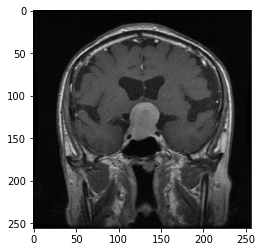

No tumor


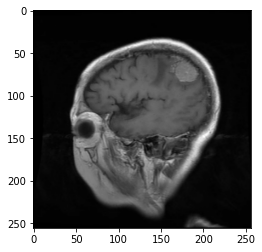

No tumor


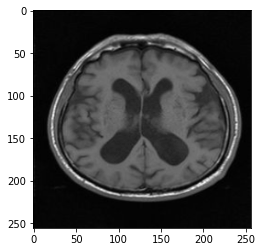

No tumor


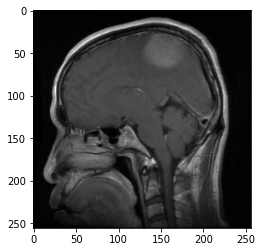

Meningioma tumor


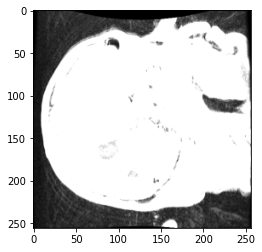

Glioma tumor


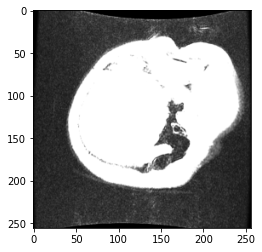

Pituitary tumor


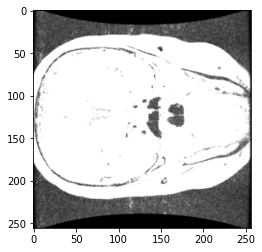

Meningioma tumor


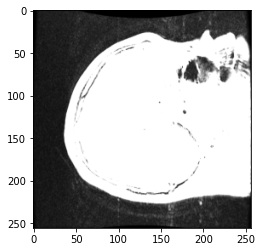

No tumor


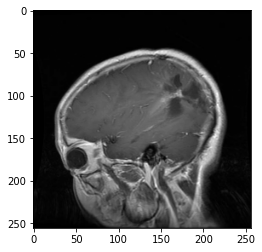

Pituitary tumor


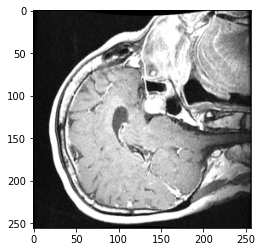

No tumor


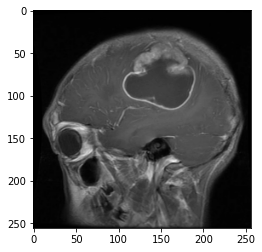

No tumor


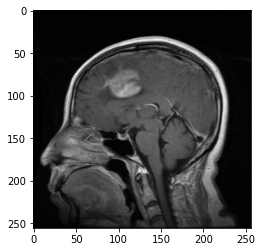

Glioma tumor


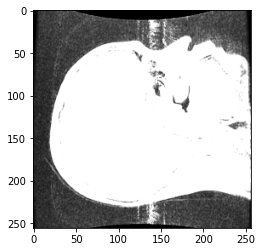

No tumor


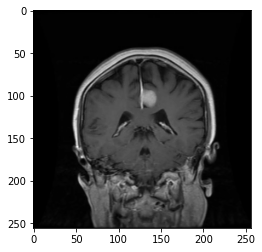

Glioma tumor


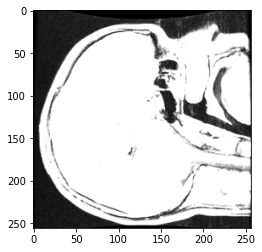

No tumor


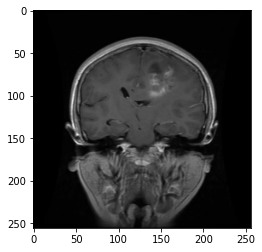

Glioma tumor


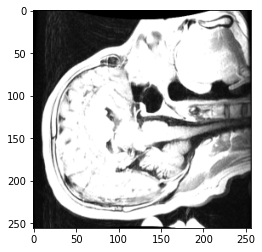

Meningioma tumor


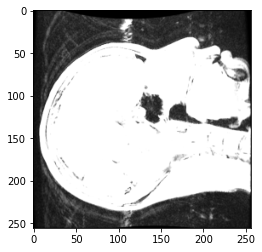

No tumor


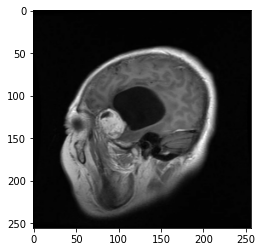

No tumor


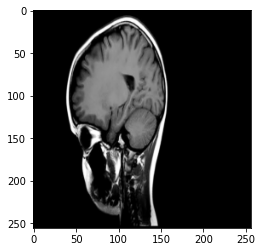

Pituitary tumor


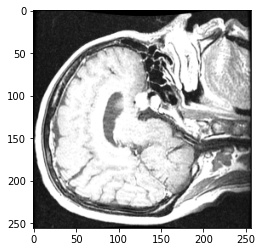

Meningioma tumor


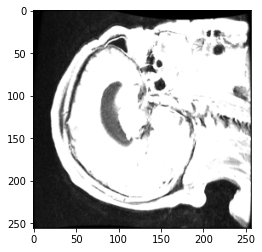

Glioma tumor


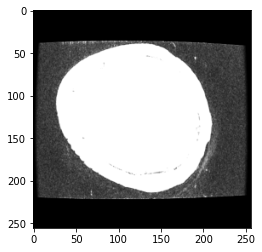

Glioma tumor


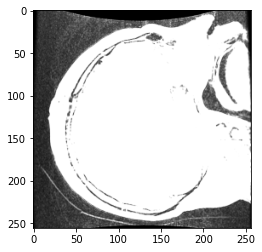

No tumor


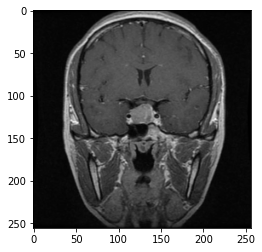

Pituitary tumor


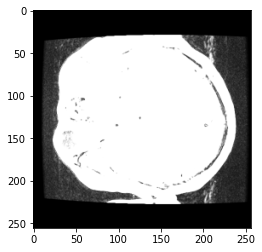

No tumor


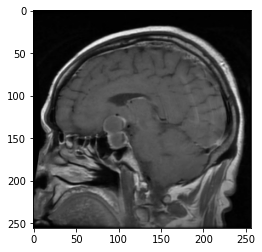

Meningioma tumor


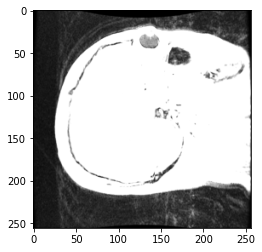

No tumor


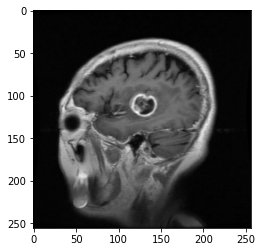

Pituitary tumor


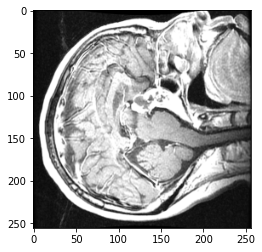

Glioma tumor


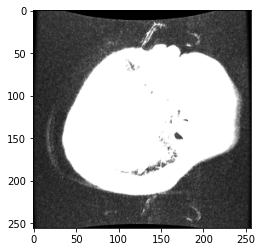

Glioma tumor


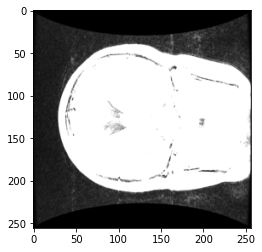

No tumor


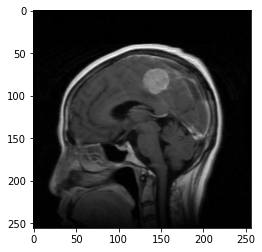

No tumor


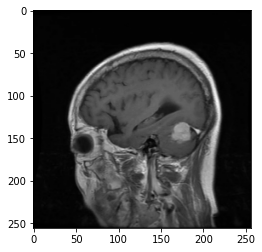

No tumor


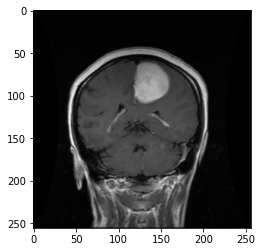

No tumor


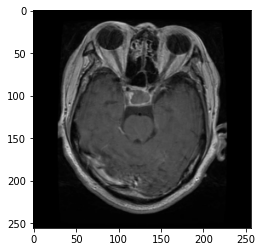

No tumor


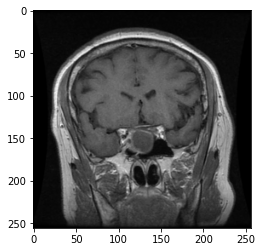

No tumor


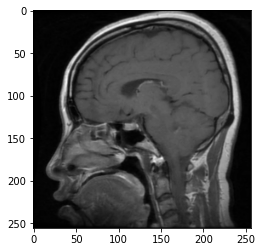

Meningioma tumor


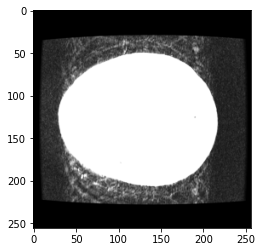

Pituitary tumor


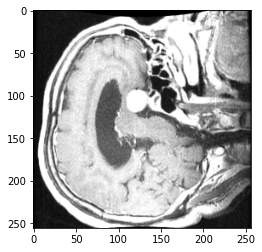

No tumor


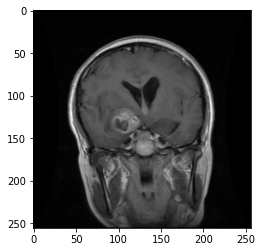

No tumor


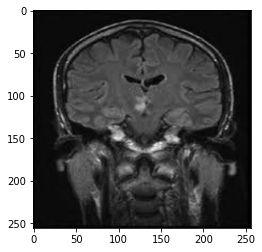

Glioma tumor


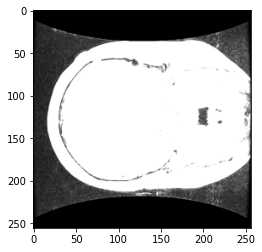

Glioma tumor


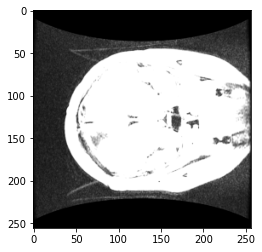

No tumor


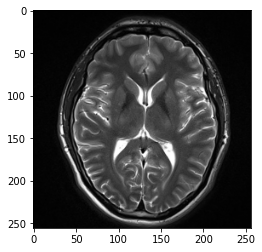

Glioma tumor


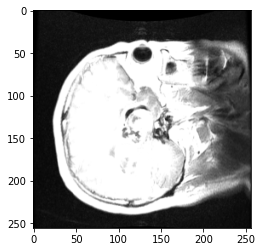

No tumor


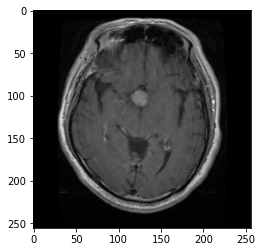

Glioma tumor


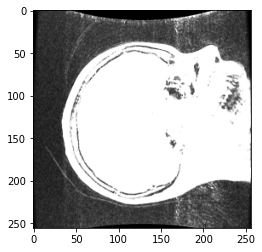

Pituitary tumor


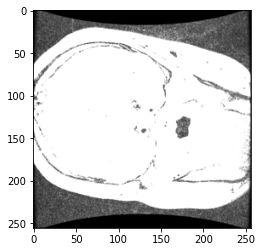

No tumor


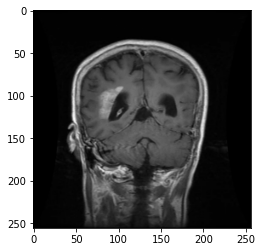

No tumor


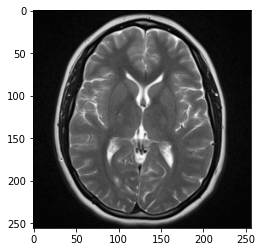

Pituitary tumor


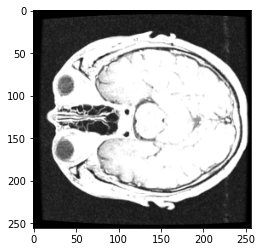

No tumor


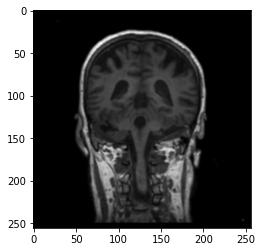

No tumor


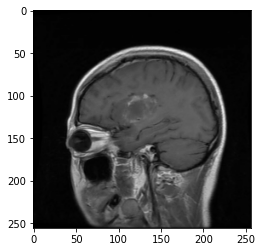

Pituitary tumor


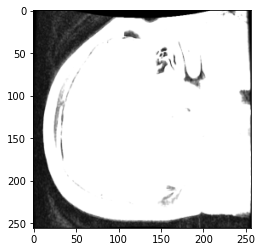

Glioma tumor


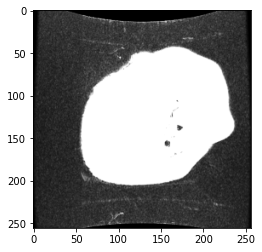

Meningioma tumor


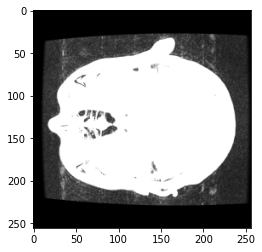

No tumor


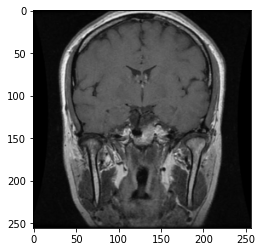

No tumor


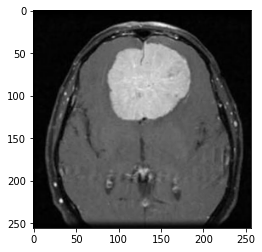

Glioma tumor


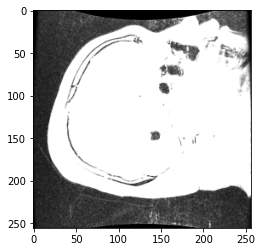

Meningioma tumor


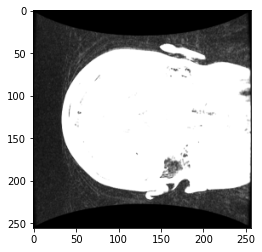

No tumor


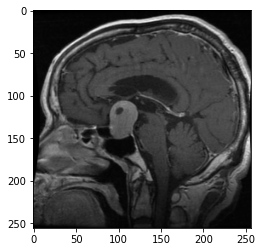

Meningioma tumor


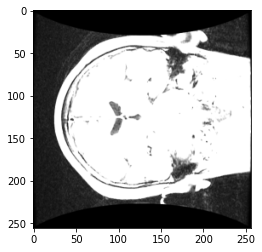

No tumor


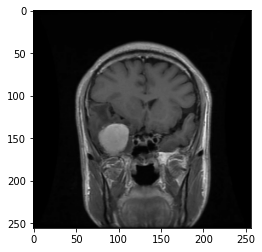

Glioma tumor


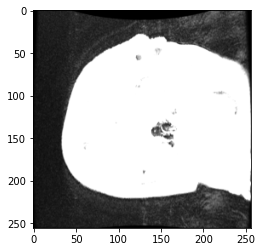

Meningioma tumor


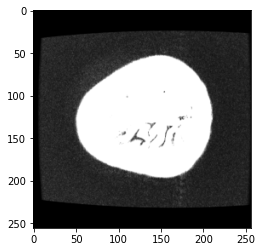

No tumor


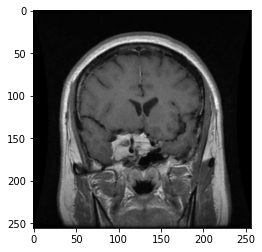

No tumor


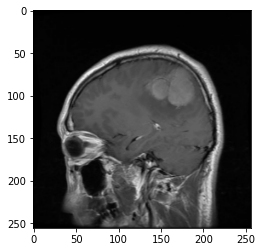

Pituitary tumor


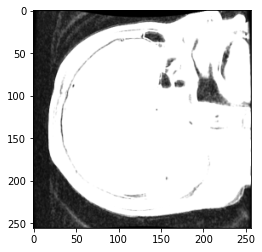

Meningioma tumor


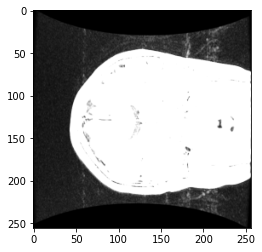

Glioma tumor


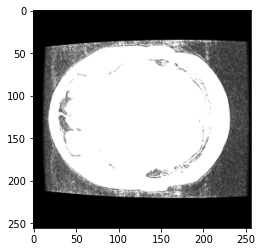

Glioma tumor


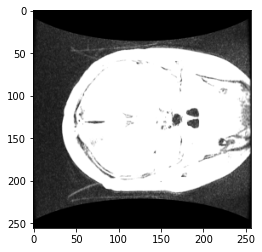

No tumor


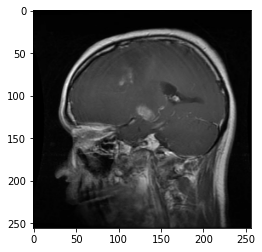

Pituitary tumor


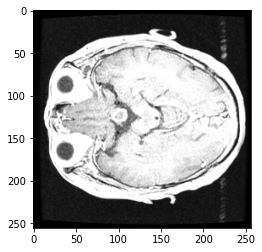

No tumor


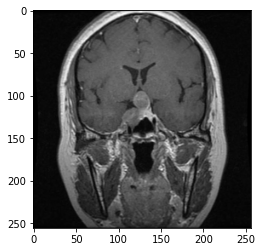

Meningioma tumor


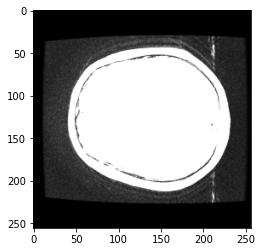

Pituitary tumor


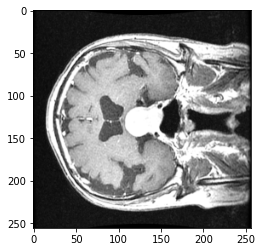

No tumor


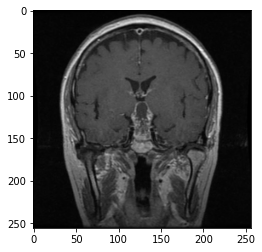

Pituitary tumor


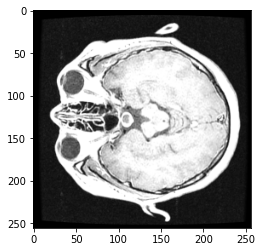

Meningioma tumor


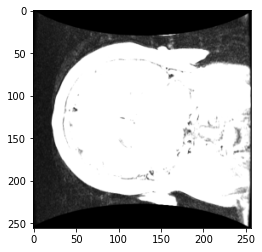

No tumor


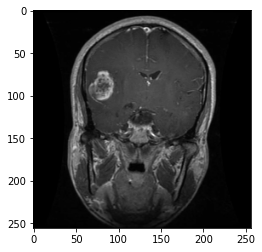

No tumor


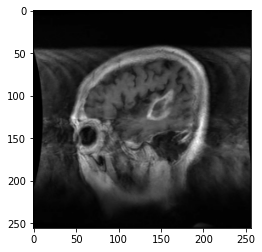

Meningioma tumor


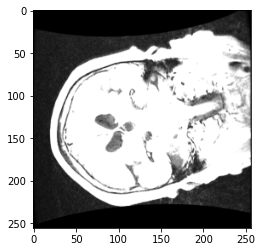

No tumor


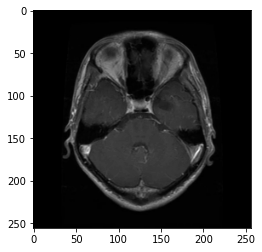

Meningioma tumor


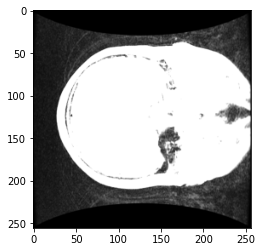

Pituitary tumor


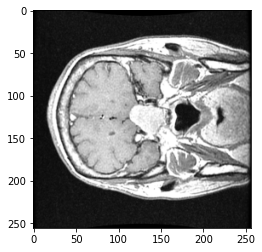

Glioma tumor


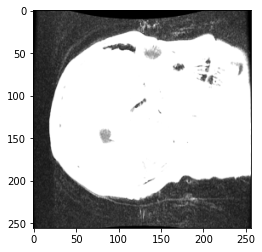

Glioma tumor


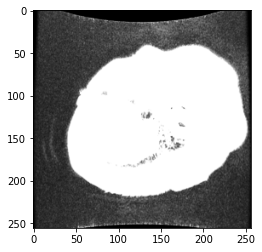

No tumor


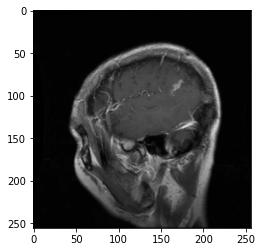

Meningioma tumor


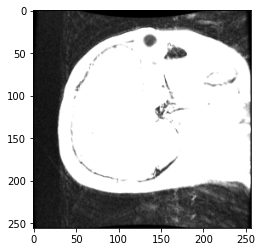

No tumor


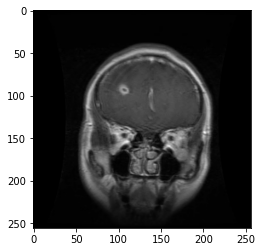

Glioma tumor


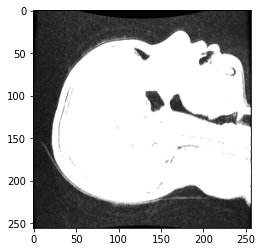

No tumor


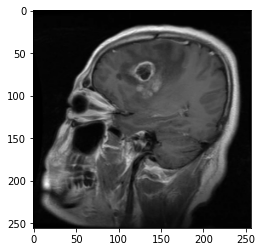

In [16]:
for x_b, y_b in train_batch_gen:
  i = 0
  plt.imshow(x_b[0, 0, ...], cmap='gray')
  print(tumor_dict[int(y_b[i])])
  plt.show()

# Creating and learning classsification model 

Selfmade classification model

In [8]:
class Flatten(nn.Module):
  def forward(self, input):
    return input.view(input.size(0), -1)

In [9]:
class Block(nn.Module):
  def __init__(self, in_channels, out_channels, kernel_size, stride=1, activation=nn.ReLU()):
    super().__init__()
    self.conv = nn.Conv2d(in_channels=in_channels,  out_channels=out_channels, kernel_size=kernel_size, stride=stride)
    self.bn = nn.BatchNorm2d(out_channels)
    self.activation = activation

  def forward(self, inputs):
    x = self.conv(inputs)
    x = self.bn(x)
    x = self.activation(x)
    return x

In [10]:
model = nn.Sequential()

model.add_module('block', Block(in_channels=1, out_channels=8, kernel_size=3))
model.add_module("maxpool1", nn.MaxPool2d(kernel_size=2, stride=2))
model.add_module('block2', Block(in_channels=8, out_channels=16, kernel_size=2))
model.add_module("maxpool3", nn.MaxPool2d(kernel_size=2, stride=2))
model.add_module("flatten", Flatten())
model.add_module('seventh3', nn.Linear(258064, 256))
model.add_module('batch', nn.BatchNorm1d(256))
model.add_module('activ', nn.ReLU())
model.add_module('seventh4', nn.Linear(256, 50))
model.add_module('batch1', nn.BatchNorm1d(50))
model.add_module('activ1', nn.ReLU())
model.add_module('eighth', nn.Linear(50, 4))
model.add_module('softmax', nn.LogSoftmax())

opt = torch.optim.Adam(model.parameters(), lr=1e-3)
compute_loss =  nn.CrossEntropyLoss()

Pretrained on CIFAR PyTorch model(ResNet18)

In [11]:
import torchvision.models as models
model = models.resnet18(pretrained=True)


model.fc = nn.Linear(in_features=512, out_features=4, bias=True)
model.conv1 = nn.Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
model.eval()

opt = torch.optim.Adam(model.parameters(), lr=1e-3)
compute_loss =  nn.CrossEntropyLoss()

model.load_state_dict(torch.load('/content/drive/MyDrive/MRI_Models/model'))
model.eval()

ResNet(
  (conv1): Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  


Let's train classification model


In [ ]:
%%time
history = []
N_EPOCHS=5
test_batch_acc = []

import time
model.train(True)
for i in range(N_EPOCHS):
    model.train(True)
    for (x_batch, y_batch) in train_batch_gen:
        
        model.train(True)
        y_pred = model(x_batch)
        loss = compute_loss(y_pred, y_batch)
        loss.backward()
        
        opt.step()
        opt.zero_grad()
        history.append(loss)
        
        model.train(False)
        for (x_batch, y_batch) in test_batch_gen:
          logits = model(x_batch)
          y_pred = logits.max(1)[1].data.numpy()
          test_batch_acc.append(np.mean(y_batch.data.numpy() == y_pred))
        torch.save(model.state_dict(), '/content/drive/MyDrive/MRI_Models/model')
    print('Accuracy on test {}%'.format(round(np.mean(test_batch_acc)*100, 2)))
    torch.save(model.state_dict(), '/content/drive/MyDrive/MRI_Models/model')

plt.plot(history)
torch.save(model.state_dict(), '/content/drive/MyDrive/MRI_Models/model')

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  from ipykernel import kernelapp as app
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:53: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


In [12]:
model.train(False)
test_batch_acc = []
for (x_batch, y_batch) in test_batch_gen:
  logits = model(x_batch)
  y_pred = logits.max(1)[1].data.numpy()
  test_batch_acc.append(np.mean(y_batch.data.numpy() == y_pred))
print('Accuracy on test {}%'.format(round(np.mean(test_batch_acc)*100, 2)))

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:53: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Accuracy on test 97.46%


# Segmentation

In [13]:
class SegmentationDataset(Dataset):
    def __init__(self, path):
        self.to_tensor = transforms.ToTensor()
        self.data_path = path
        self.data_len = len(self.data_path)
        

    def __getitem__(self, index):
        
        f = h5py.File(self.data_path[index],'r')
        img_as_img = resize(np.array(Image.fromarray(np.array((f.get('cjdata/image')))).convert('L')), [256, 256])
        img_as_tensor = self.to_tensor(img_as_img)
        img_as_tensor = torch.tensor(img_as_tensor, dtype=torch.float32)
        mask_as_img = img_as_img = resize(np.array(Image.fromarray(np.array((f.get('cjdata/tumorMask')))).convert('L')), [256, 256])
        mask_as_tensor = self.to_tensor(mask_as_img)
        mask_as_tensor = torch.tensor(mask_as_tensor, dtype=torch.float32)
        return (img_as_tensor, mask_as_tensor)


    def __len__(self):
        return self.data_len


In [14]:
Segmentation_training_dataset = SegmentationDataset(path = train_images_path[:2500])
Segmentation_testing_dataset = SegmentationDataset(path = train_images_path[2500:])

In [15]:
batch_size = 64
train_batch_gen_ = torch.utils.data.DataLoader(Segmentation_training_dataset, 
                                              batch_size=batch_size,
                                              shuffle=True)

test_batch_gen_ = torch.utils.data.DataLoader(Testing_dataset, 
                                              batch_size=batch_size,
                                              shuffle=True)

In [16]:
def calc_iou(prediction, ground_truth):
    n_images = len(prediction)
    intersection, union = 0, 0
    for i in range(n_images):
        intersection += np.logical_and(prediction[i] > 0, ground_truth[i] > 0).astype(np.float32).sum() 
        union += np.logical_or(prediction[i] > 0, ground_truth[i] > 0).astype(np.float32).sum()
    return float(intersection) / union

In [17]:
class MyUnet(nn.Module):
    def __init__(self, filters):
        super(MyUnet, self).__init__()
        self.filters = filters

        encoder_layers = []
        in_filters = 1
        for i, ifilters in enumerate(filters):            
            encoder_layers.append(nn.ModuleList([
                nn.MaxPool2d(2),

                nn.Conv2d(in_filters, ifilters, kernel_size=3, padding=1),
                nn.BatchNorm2d(ifilters),
                nn.ReLU(),

                nn.Conv2d(ifilters, ifilters, kernel_size=3, padding=1),
                nn.BatchNorm2d(ifilters),
                nn.ReLU(),
            ]))
            in_filters = ifilters
        self.encoder_list = encoder_layers
        [self.add_module('encoder_' + str(i), layer) for i, layer in enumerate(list(itertools.chain(*self.encoder_list)))]

        decoder_layers = []
        for i in range(len(filters) - 1):
            print(i)
            print('filters ', -i -2,  '', filters[-i-2])
            decoder_layers.append(([
                nn.ConvTranspose2d(filters[-i - 1], filters[-i - 2], kernel_size=2, stride=2),
                nn.Conv2d(filters[-i - 1], filters[-i - 2], kernel_size=3, padding=1),
                nn.BatchNorm2d(filters[-i - 2]),
                nn.ReLU(),

                nn.Conv2d(filters[-i - 2], filters[-i - 2], kernel_size=3, padding=1),
                nn.BatchNorm2d(filters[-i - 2]),
                nn.ReLU()
                ]))
        decoder_layers.append(
            ([nn.ConvTranspose2d(filters[0], filters[0], kernel_size=2, stride=2)]))
        
        self.decoder_list = decoder_layers
        self.encoder_outputs = []
        [self.add_module('decoder_' + str(i), layer) for i, layer in enumerate(list(itertools.chain(*self.decoder_list)))]
        
        self.head_list = [nn.Conv2d(filters[0], 1, kernel_size=1), nn.Sigmoid()]
        [self.add_module('my_head' + str(i), layer) for i, layer in enumerate(self.head_list)]

    def encoder(self, x):
        output = x
        for i, block in enumerate(self.encoder_list):
            for j, layer in enumerate(block):
                output = layer(output)
            self.encoder_outputs.append(output)
        return output

    def decoder(self, x):
        output = x
        for i, block in enumerate(self.decoder_list[:-1]):
            upsampled_x = block[0](output)
            encoder_tensor = self.encoder_outputs[-i - 2]
            output = torch.cat([encoder_tensor, upsampled_x], 1)
            for j, layer in enumerate(block[1:]):
                output = layer(output)
        output = self.decoder_list[-1][0](output)
        return output
            
    def forward(self, x):
        encoder_output = self.encoder(x)
        decoder_output = self.decoder(encoder_output)
        output = self.head_list[0](decoder_output)
        self.encoder_outputs = []
        return self.head_list[1](output)

my_filters = [10, 20, 40]

seg_model = MyUnet(my_filters)
opt = torch.optim.Adam(seg_model.parameters(), lr=1e-3)
compute_loss =  nn.BCELoss()

0
filters  -2  20
1
filters  -3  10


In [24]:
seg_model = torch.hub.load('mateuszbuda/brain-segmentation-pytorch', 'unet',
    in_channels=3, out_channels=1, init_features=32, pretrained=True)

seg_model.encoder1.enc1conv1 = nn.Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
seg_model.eval()

opt = torch.optim.Adam(seg_model.parameters(), lr=1e-3)
compute_loss =  nn.BCELoss()

Using cache found in /root/.cache/torch/hub/mateuszbuda_brain-segmentation-pytorch_master


In [ ]:
%%time
history = []
N_EPOCHS=2
test_accuracy = []
use_cuda = torch.cuda.is_available()
dtype = torch.cuda.FloatTensor if use_cuda else torch.FloatTensor

for i in range(N_EPOCHS):
    start_time = time.time()
    seg_model.train(True)
    for (x_batch, y_batch) in train_batch_gen_:
        y_pred = seg_model(x_batch)
        loss = compute_loss(y_pred, y_batch)
        loss.backward()
        opt.step()

        opt.zero_grad()
        history.append(loss)

        seg_model.train(False)
        for X_batch, y_batch in test_batch_gen_:

          logits = seg_model(torch.FloatTensor(X_batch)).cpu().data.numpy()
          y_pred = (logits > 0.3).astype(np.float32)

          test_accuracy.append(calc_iou(y_pred.cpu(), y_batch.cpu().data.numpy()))

    print("Epoch {} of {} took {:.3f}s".format(
            i + 1, N_EPOCHS, time.time() - start_time))
    print("  test accuracy: \t\t\t{:.2f} %".format(
            np.mean(test_accuracy[-1]) * 100))
    

plt.plot(history)
torch.save(seg_model.state_dict(), '/content/drive/MyDrive/MRI_Models')

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:13: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  del sys.path[0]
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:16: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  app.launch_new_instance()


# Creating final algoritm

In [ ]:
import torchvision.models as model
model = models.resnet18(pretrained=True)
model.fc = nn.Linear(in_features=512, out_features=4, bias=True)
model.conv1 = nn.Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
model.eval()
model.load_state_dict(torch.load('/content/drive/MyDrive/MRI_Models/model'))
model.eval()

seg_model = torch.hub.load('mateuszbuda/brain-segmentation-pytorch', 'unet',
    in_channels=3, out_channels=1, init_features=32, pretrained=True)
seg_model.encoder1.enc1conv1 = nn.Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
seg_model.eval()
seg_model.load_state_dict(torch.load('/content/drive/MyDrive/MRI_Models/seg_model'))

In [ ]:
image_path = input('Введите путь до необходимого изображения: \n')
img_as_img = resize(np.array(Image.open(image_path).convert('L')), [256, 256])
img_as_tensor = torch.tensor(img_as_img, dtype=torch.float32)

logits = model(img_as_tensor) 
y_pred = logits.max(1)[1].data.numpy()

logits = seg_model(torch.FloatTensor(img_as_tensor)).data.numpy()
y_pred = (logits > 0.3).astype(np.float32)

print(tumor_dict[y_pred])
plt.imshow(img_as_tensor, cmap='gray')